# Xarray

## Goal
We will use in this section of the workshop xarray to write our data to netCDF files because it is very convenient to do so by means of this library. The main idea is to build your data set including attibutes and write it in the end to a file.

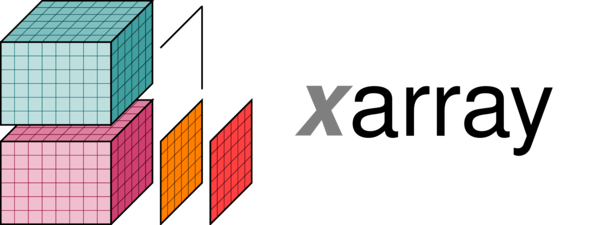

In [1]:
from IPython.display import Image
Image('http://xarray.pydata.org/en/stable/_static/dataset-diagram-logo.png')

### Overview

* for __N-dimensional arrays__

* for geoscientists who need to use __netCDF__.

* attaches __Dimensions__ indexes and __Coordinate__ names to numpy’s ndarray

Source of this introduction: [Xarray Documentation](http://xarray.pydata.org/en/stable/index.html).

___
### Getting started

In [2]:
# Import standard packages
%matplotlib notebook
import matplotlib.pyplot as plt
plt.ioff() # turn off interactive plotting mode
import numpy as np
import pandas as pd
# Xarray is conventionally imported as 'xr'
import xarray as xr

___
### Core data structures <a name="data_structures"></a>

Xarray provides two core data structures:

* __DataArray__ is a __labeled, N-dimensional array__ (similar to _pandas.Series_)
    
* __Dataset__ is a multi-dimensional, dict-like __container of DataArray__ objects with shared dimensions (similar to _pandas.DataFrame_)

#### Dataset

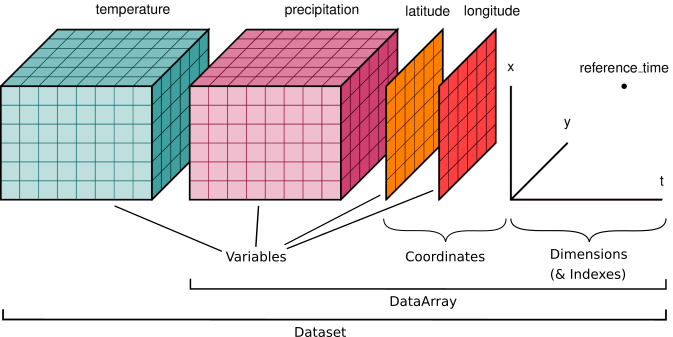

In [3]:
Image('http://xarray.pydata.org/en/stable/_images/dataset-diagram.png')

Datasets have four key properties:

* `dims`: a dictionary mapping from dimension names to the fixed length of each dimension (e.g., `{'x': 6, 'y': 6, 'time': 8}`)
* `data_vars`: a multi-dimensional array of values (e.g., a Numpy ndarray, DataFrame) 
* `coords`: dict-like container of arrays intended to label points used in `data_vars` (e.g., arrays of positional numbers, datetime objects or strings)
* `attrs`: a dict to hold arbitrary metadata

### Creating a Dataset: 4 measurement stations
Here we create a data set of 4 time series which have the same number of elements and the time values are identical for all instances. The recommendation of the CF conventions according to the appendix _H.2.1. Orthogonal multidimensional array representation of time series_ shows how to deal with these kind of data: 
http://cfconventions.org/Data/cf-conventions/cf-conventions-1.10/cf-conventions.html#_orthogonal_multidimensional_array_representation_of_time_series

In our example we assume:
- 4 stations with random locations in North America
- 365 measurements (daily in the year 2022) per station
- parameters: 2m air temperature, precipitation

In [4]:
# Make up dummy temperature and precip data_vars for four locations
temp = 15 + 8 * np.random.rand(365, 4) # 2 dim array (time, station)
precip = 10 * np.random.rand(365, 4) 
# create 365 time steps
times = pd.date_range('2022', freq='d', periods=365)
# Set up arbitrary coordinates
lons = [-99.83, -90.32, -80.79, -75.23]
lats = [42.25, 41.21, 40.63, 39.59]

In [5]:
# Map plot, to show the locations on a map
import cartopy as cp
import cartopy.crs as ccrs
plt.figure(figsize=(10,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()
for i in range(4):
    plt.text(lons[i], lats[i], 's'+str(i))
plt.show()    

<IPython.core.display.Javascript object>

### How to create a Dataset object in xarray
In the Dataset constructor you have to provide the coordinates, dimensions and variables:
- The coordinates *time, lat, lon* are defined in a dict **coords** as keys
- The variables *temperature, precipitation* are defined in a dict **data_vars** as keys
- The dimensions *time, station* are defined as the first entry of your dict value tuple
- The actual data arrays are provided as the second entry of your dict value tuple

In [6]:
ds = xr.Dataset(data_vars={'temperature': (['time', 'station'],  temp),
                           'precipitation': (['time', 'station'],  precip),},
                coords={'lon': ('station', lons),
                        'lat': ('station', lats),
                        'time': ('time', times),})

#### Overview of the Dataset:
There are two different ways to get an overview of the Dataset object:
- **ds** shows the dimensions, coordinates and data variables including some content
- **ds.info()** provides a ncdump-like result of the meta data header 

In [7]:
ds

<xarray.Dataset>
Dimensions:        (time: 365, station: 4)
Coordinates:
    lon            (station) float64 -99.83 -90.32 -80.79 -75.23
    lat            (station) float64 42.25 41.21 40.63 39.59
  * time           (time) datetime64[ns] 2022-01-01 2022-01-02 ... 2022-12-31
Dimensions without coordinates: station
Data variables:
    temperature    (time, station) float64 17.1 16.35 22.76 ... 21.7 22.3 16.49
    precipitation  (time, station) float64 0.708 5.617 2.109 ... 7.945 4.148

In [8]:
ds.info()

xarray.Dataset {
dimensions:
	time = 365 ;
	station = 4 ;

variables:
	float64 temperature(time, station) ;
	float64 precipitation(time, station) ;
	float64 lon(station) ;
	float64 lat(station) ;
	datetime64[ns] time(time) ;

// global attributes:
}

#### Access the DataArray objects
To add some meta data to our Dataset object we need to know how to access single variables:

In [9]:
ds['temperature'] # label-based indexing

<xarray.DataArray 'temperature' (time: 365, station: 4)>
array([[17.10206371, 16.34820882, 22.761225  , 20.50293194],
       [20.59802016, 20.04048841, 19.44919003, 15.20868277],
       [21.36387422, 18.19115893, 15.25248817, 21.11277936],
       ...,
       [22.23935982, 21.30643168, 21.48933975, 18.11288068],
       [20.86509514, 22.41466637, 18.20696127, 16.90107699],
       [20.28108647, 21.70009547, 22.30000524, 16.49253144]])
Coordinates:
    lon      (station) float64 -99.83 -90.32 -80.79 -75.23
    lat      (station) float64 42.25 41.21 40.63 39.59
  * time     (time) datetime64[ns] 2022-01-01 2022-01-02 ... 2022-12-31
Dimensions without coordinates: station

#### Add Metadata
To make our Dataset CF compliant we need some attributes. This example is not complete, it is only supposed to show you how to add attributes to variables and coordinates. In xarray Datasets this is simply done by adding *.attrs* and assigning the desired attributes in a dict.

In [10]:
ds['temperature'].attrs = {'units': 'K', 'standard_name': 'air_temperature'}
ds['precipitation'].attrs = {'units': 'kg m-2', 'standard_name': 'precipitation_amount'}
ds['lon'].attrs = {'units': 'degrees_east'}
ds['lat'].attrs = {'units': 'degrees_north'}
ds.attrs = {'description': 'monthly precipitation and temperature data at 4 stations in North America', 
            'contact': 'remon.sadikni@uni-hamburg.de', 
            'institution': 'ICDC, CEN, University Hamburg'}

Regarding the time variable, we don't need to provide all attributes because xarray will provide the units and calendar attribute for us. Unfortunately we cannot see that in the output of ds.info() but we will see this later when we look at the real netCDF header of ncdump. 

In [11]:
ds.info()

xarray.Dataset {
dimensions:
	time = 365 ;
	station = 4 ;

variables:
	float64 temperature(time, station) ;
		temperature:units = K ;
		temperature:standard_name = air_temperature ;
	float64 precipitation(time, station) ;
		precipitation:units = kg m-2 ;
		precipitation:standard_name = precipitation_amount ;
	float64 lon(station) ;
		lon:units = degrees_east ;
	float64 lat(station) ;
		lat:units = degrees_north ;
	datetime64[ns] time(time) ;

// global attributes:
	:description = monthly precipitation and temperature data at 4 stations in North America ;
	:contact = remon.sadikni@uni-hamburg.de ;
	:institution = ICDC, CEN, University Hamburg ;
}

___
### Input / Output <a name="input_output"></a>

You can directly write Xarray objects to disk using `to_netcdf()`

#### Write netCDF file
You can write your Dataset to a netCDF by using .to_netcdf(FILENAME):

In [12]:
ds.to_netcdf('random_temp_precip.nc')

#### Checking the content of the netCDF files
Let's have a look at the header of the netCDF file via ncdump:
- there are some additional attributes that we did not set such as the time units

In [13]:
!ncdump -h random_temp_precip.nc


netcdf random_temp_precip {
dimensions:
	time = 365 ;
	station = 4 ;
variables:
	double temperature(time, station) ;
		temperature:_FillValue = NaN ;
		temperature:units = "K" ;
		temperature:standard_name = "air_temperature" ;
		temperature:coordinates = "lat lon" ;
	double precipitation(time, station) ;
		precipitation:_FillValue = NaN ;
		precipitation:units = "kg m-2" ;
		precipitation:standard_name = "precipitation_amount" ;
		precipitation:coordinates = "lat lon" ;
	double lon(station) ;
		lon:_FillValue = NaN ;
		lon:units = "degrees_east" ;
	double lat(station) ;
		lat:_FillValue = NaN ;
		lat:units = "degrees_north" ;
	int64 time(time) ;
		time:units = "days since 2022-01-01 00:00:00" ;
		time:calendar = "proleptic_gregorian" ;

// global attributes:
		:description = "monthly precipitation and temperature data at 4 stations in North America" ;
		:contact = "remon.sadikni@uni-hamburg.de" ;
		:institution = "ICDC, CEN, University Hamburg" ;
}


#### Read netCDF file
Reading in netCDF files in xarray is also simple:

In [14]:
ds = xr.open_dataset('random_temp_precip.nc')

In [15]:
ds["temperature"][:,0].plot() # time series plot of station 0
plt.show()

<IPython.core.display.Javascript object>

### Links <a name="exercises_links"></a>
* [Offical Xarray Documentation](http://xarray.pydata.org/en/stable/index.html)
* This was only an introduction to Xarray. There are many more features left to be explored.